--- Starting Training ---
Environment: Max Inventory=15, Avg Demand=2.5, Avg Delay=3
Training for 15000 episodes...
Episode 1500/15000...
Episode 3000/15000...
Episode 4500/15000...
Episode 6000/15000...
Episode 7500/15000...
Episode 9000/15000...
Episode 10500/15000...
Episode 12000/15000...
Episode 13500/15000...
--- Training Complete ---

--- Generating Performance Plots ---


/var/folders/73/1wstfjwn76s193_38n9l19_h0000gn/T/ipykernel_48108/107604163.py:568: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(agent_names, rotation=20)


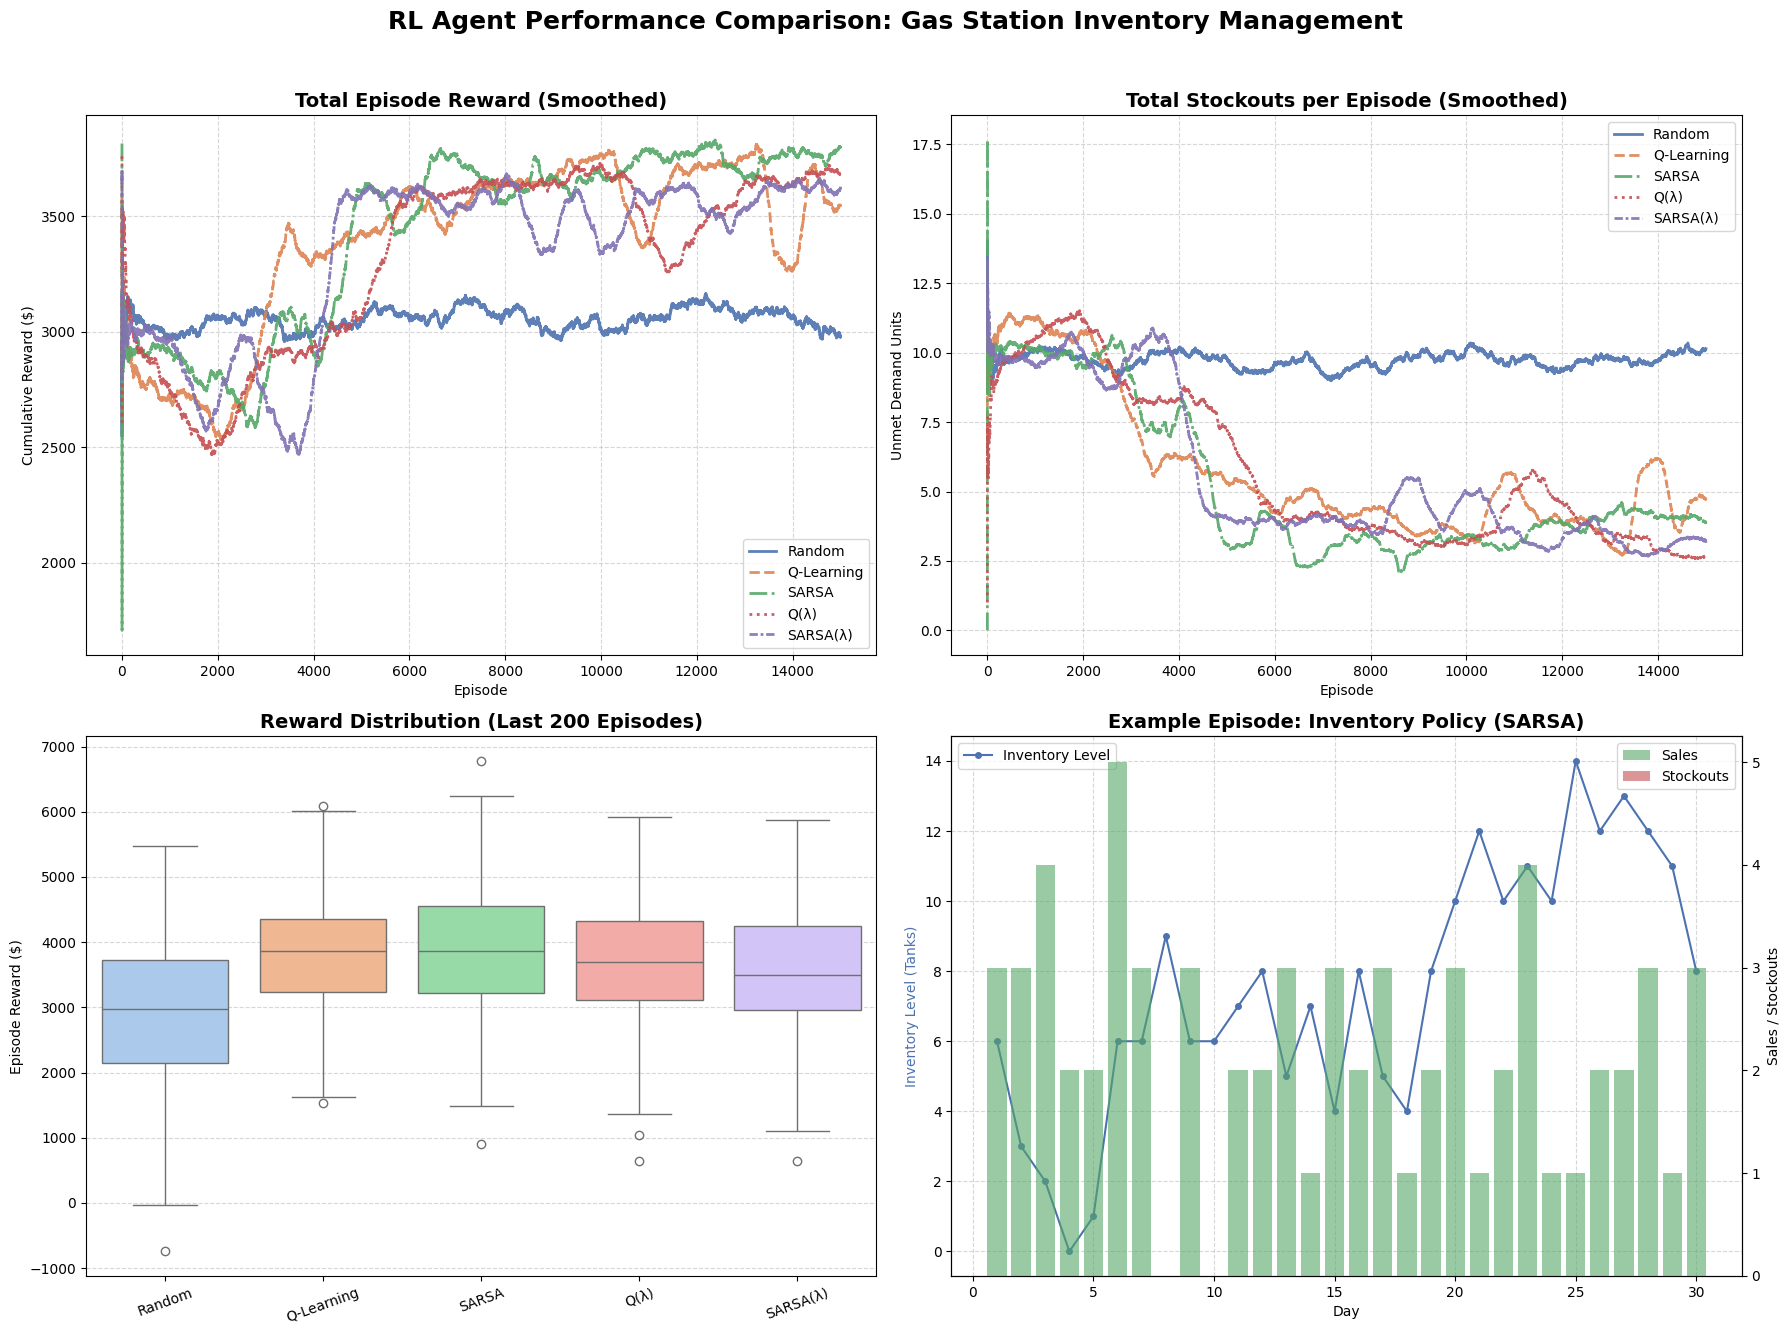


                FINAL PERFORMANCE SUMMARY (Last 200 Episodes)
Agent        |   Avg Reward |    Std Dev |   Avg Profit |   Avg Stockouts
--------------------------------------------------------------------------------
Random       | $    2886.35 | $  1185.91 | $    2886.35 |           10.80
Q-Learning   | $    3810.75 | $   822.92 | $    3810.75 |            2.96
SARSA        | $    3886.32 | $   963.65 | $    3886.32 |            3.39
Q(λ)         | $    3701.62 | $   918.62 | $    3701.62 |            2.91
SARSA(λ)     | $    3542.10 | $  1001.97 | $    3542.10 |            3.24

--- Key Business & Algorithm Insights ---
1. Value of Intelligence: The best RL agent increased average episode profit by $999.97 compared to a random policy (34.6% improvement).
2. On-policy vs. Off-policy: SARSA (on-policy) learns a potentially more conservative policy because it accounts for exploratory actions during updates. In this run, Q-Learning achieved lower rewards. SARSA resulted in more stockout

In [3]:
# necessary imports
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, deque
import seaborn as sns
from dataclasses import dataclass
from typing import Tuple, Dict, List, Any
import pandas as pd
import itertools

# Listing 1: Environment Configuration and Data Classes
@dataclass
class GasStationConfig:
    """Configuration class for gas station inventory environment parameters."""
    # --- Capacity and Time ---
    max_inventory: int = 10         # Maximum fuel tanks capacity a station can hold
    initial_inventory: int = 4      # Starting inventory level
    planning_horizon: int = 30      # Planning period in days for one episode simulation

    # --- Demand Dynamics ---
    demand_mean: float = 2.0        # Average daily demand in tanks
    demand_std_dev_factor: float = 0.5 # Standard deviation as a factor of the mean
    demand_min: float = 0.0         # Minimum possible demand (cannot be negative)
    demand_max: float = 10.0        # Maximum possible demand (clipping value)

    # --- Supply Chain Dynamics ---
    delivery_delay_mean: int = 2    # Average delivery time in days (Poisson distribution mean)
    min_delivery_delay: int = 1     # Minimum possible delivery time

    # --- Financial Model ---
    profit_per_tank: float = 100.0  # Revenue minus variable cost per tank sold
    stockout_penalty: float = 80.0  # Cost per unit of unmet demand (lost goodwill, customer churn)
    holding_cost_per_tank: float = 5.0 # Cost per tank per day held in inventory (capital cost, storage)
    ordering_cost: float = 20.0     # Fixed cost per order placed, regardless of quantity

@dataclass
class EnvironmentState:
    """State representation for the gas station environment."""
    current_inventory: int                # Current fuel tanks on hand
    pending_orders: List[Tuple[int, int]] # List of tuples: [(quantity, days_remaining), ...]

    # --- Educational Note: State Space Design ---
    # The key to making tabular RL work is to define a state space that is:
    # 1. Markovian: The current state contains enough information to predict the future,
    #    without needing history (e.g., knowing pending orders is crucial).
    # 2. Tractable: Small enough for the agent to explore sufficiently.
    #
    # Firstly, we desgined the state to have `day` and `recent_demand`, leading to millions of states.
    # We simplify by removing `day` (assuming an infinite horizon problem, where the policy
    # becomes stationary) and `recent_demand` (letting the agent learn the average demand
    # implicitly through experience).

    def to_tuple(self) -> Tuple:
        """
        Convert complex state object into a simplified tuple for Q-table lookups.
        This feature engineering step is critical for tabular methods.

        Returns:
            Tuple representing the state: (current_inventory, pending_sum, next_arrival_time)
        """
        # Feature 1: Current inventory level.
        inventory = self.current_inventory

        # Feature 2: Total quantity of fuel in transit.
        # This tells the agent about future supply replenishment.
        pending_sum = sum(quantity for quantity, days_left in self.pending_orders)

        # Feature 3: Time until the next delivery arrives.
        # This informs the agent about the immediacy of supply relief.
        # If no orders are pending, we use a distinct value (e.g., 0 or -1). Let's use 0.
        if self.pending_orders:
            next_arrival_time = min(days_left for _, days_left in self.pending_orders)
        else:
            next_arrival_time = 0 # Special value indicating no incoming orders.

        # To keep state space even smaller, we can cap the values for pending_sum and next_arrival_time.
        # For example, cap pending_sum at max_inventory * 1.5 and next_arrival_time at delivery_delay_mean * 2.
        # Example cap: pending_sum = min(pending_sum, 15)
        # Example cap: next_arrival_time = min(next_arrival_time, 5)
        # We recommend experimenting with these caps by yourself.

        return (inventory, pending_sum, next_arrival_time)

# Listing 2: Gas Station Inventory Environment
class GasStationEnvironment:
    """
    Simulates the daily operations of a gas station inventory system.
    The agent's goal is to learn an ordering policy that maximizes profit
    by balancing sales revenue against holding costs and stockout penalties.
    """

    def __init__(self, config: GasStationConfig):
        self.config = config
        self.action_space_size = 6  # Actions 0 (no order) through 5 (order 5 tanks)
        self.reset()

    def reset(self) -> EnvironmentState:
        """Resets the environment to the initial state for a new episode."""
        self.state = EnvironmentState(
            current_inventory=self.config.initial_inventory,
            pending_orders=[]
        )
        self.current_day = 0

        # Episode-specific metrics tracking
        self.total_profit = 0.0
        self.total_stockouts = 0.0
        self.total_sales = 0.0
        self.episode_log = [] # To store detailed daily activity

        return self.state

    def _generate_demand(self) -> float:
        """Generates stochastic demand for the day."""
        # Use a normal distribution, ensuring non-negative demand and applying a cap.
        demand = np.random.normal(
            self.config.demand_mean,
            self.config.demand_mean * self.config.demand_std_dev_factor
        )
        return np.clip(demand, self.config.demand_min, self.config.demand_max)

    def _process_deliveries(self):
        """Processes incoming fuel deliveries and updates inventory."""
        arrived_today = 0
        remaining_orders = []

        # Update order timers and check for arrivals
        for quantity, days_remaining in self.state.pending_orders:
            if days_remaining <= 1:
                arrived_today += quantity
            else:
                remaining_orders.append((quantity, days_remaining - 1))

        self.state.pending_orders = remaining_orders

        # Add arrived fuel to inventory, respecting maximum capacity constraint.
        # Wasted fuel (delivery exceeding capacity) is implicitly penalized.
        space_available = self.config.max_inventory - self.state.current_inventory
        delivered_quantity = min(arrived_today, space_available)
        self.state.current_inventory += delivered_quantity

    def _handle_demand(self, demand: float) -> Tuple[float, float]:
        """Calculates sales and stockouts based on demand and current inventory."""
        # Round demand to nearest integer customer unit for discrete sales.
        demand_units = int(np.round(demand))

        if demand_units <= 0:
            return 0.0, 0.0

        # Calculate sales based on available inventory
        sales = min(self.state.current_inventory, demand_units)
        stockout = demand_units - sales

        # Update inventory level
        self.state.current_inventory -= sales

        return float(sales), float(stockout)

    def step(self, action: int) -> Tuple[EnvironmentState, float, bool, Dict]:
        """Executes one time step (day) in the environment."""
        # 1. Process new order based on agent's action
        order_cost = 0.0
        if action > 0:
            # Calculate stochastic delivery lead time for this new order
            delivery_delay = max(
                self.config.min_delivery_delay,
                np.random.poisson(self.config.delivery_delay_mean)
            )
            self.state.pending_orders.append((action, delivery_delay))
            order_cost = self.config.ordering_cost

        # 2. Receive deliveries scheduled for today (occurs at start of day)
        inventory_before_sales = self.state.current_inventory
        self._process_deliveries()

        # 3. Generate customer demand for the day
        demand = self._generate_demand()

        # 4. Fulfill demand and calculate sales/stockouts
        sales, stockout = self._handle_demand(demand)

        # 5. Calculate daily reward components
        sales_revenue = sales * self.config.profit_per_tank
        stockout_cost = stockout * self.config.stockout_penalty
        # Holding cost is calculated based on end-of-day inventory
        holding_cost = self.state.current_inventory * self.config.holding_cost_per_tank

        daily_reward = sales_revenue - stockout_cost - holding_cost - order_cost

        # 6. Update environment time and check for episode completion
        self.current_day += 1
        done = self.current_day >= self.config.planning_horizon

        # 7. Update cumulative metrics for analysis
        self.total_profit += daily_reward
        self.total_stockouts += stockout
        self.total_sales += sales

        # Prepare info dictionary for logging and analysis
        info = {
            'demand': demand,
            'sales': sales,
            'stockout': stockout,
            'inventory_end': self.state.current_inventory,
            'total_profit': self.total_profit,
            # BUG FIX: Add 'action' to info dict for external analysis functions.
            'action': action
        }
        self.episode_log.append(info)

        return self.state, daily_reward, done, info

    def get_action_space_size(self) -> int:
        return self.action_space_size

# Listing 3: Epsilon-Greedy Policy Implementation
class EpsilonGreedyPolicy:
    """Epsilon-greedy exploration strategy for value-based methods."""

    def __init__(self, epsilon_start: float = 1.0, epsilon_end: float = 0.01,
                 epsilon_decay: float = 0.9995):
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay

    def select_action(self, q_values: np.ndarray) -> int:
        """Select action using epsilon-greedy policy."""
        if np.random.random() < self.epsilon:
            # Explore: choose a random action
            return np.random.randint(len(q_values))
        else:
            # Exploit: choose the action with the highest Q-value
            return np.argmax(q_values)

    def decay_epsilon(self):
        """Decay exploration rate."""
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

# Listing 4: Base Agent Class and Random Agent
class BaseAgent:
    """Base class for all RL agents."""
    def __init__(self, action_space_size: int, name: str):
        self.action_space_size = action_space_size
        self.name = name
        self.q_table = defaultdict(lambda: np.zeros(action_space_size))
        # Metrics storage for each agent
        self.episode_rewards = []
        self.episode_profits = []
        self.episode_stockouts = []

    def select_action(self, state: EnvironmentState) -> int:
        raise NotImplementedError

    def update(self, state: EnvironmentState, action: int, reward: float,
               next_state: EnvironmentState, next_action: int, done: bool):
        pass # next_action is only used by SARSA, ignored by Q-learning

    def reset_episode(self):
        pass

class RandomAgent(BaseAgent):
    """Random agent that selects actions uniformly at random."""
    def __init__(self, action_space_size: int):
        super().__init__(action_space_size, "Random")

    def select_action(self, state: EnvironmentState) -> int:
        return np.random.randint(0, self.action_space_size)

# Listing 5: Q-Learning Agent Implementation
class QLearningAgent(BaseAgent):
    """
    Q-Learning Agent (Off-Policy TD Control).
    Learns the value of taking action 'a' from state 's' by greedily selecting
    the best possible action in the next state, regardless of the policy actually followed.
    Update rule: Q(s,a) <- Q(s,a) + alpha * [r + gamma * max_a' Q(s',a') - Q(s,a)]
    """
    def __init__(self, action_space_size: int, learning_rate: float,
                 discount_factor: float, epsilon_start: float, epsilon_decay: float):
        super().__init__(action_space_size, "Q-Learning")
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.policy = EpsilonGreedyPolicy(epsilon_start, epsilon_decay=epsilon_decay)

    def select_action(self, state: EnvironmentState) -> int:
        state_key = state.to_tuple()
        q_values = self.q_table[state_key]
        return self.policy.select_action(q_values)

    def update(self, state: EnvironmentState, action: int, reward: float,
               next_state: EnvironmentState, next_action: int, done: bool):
        state_key = state.to_tuple()
        next_state_key = next_state.to_tuple()

        # Calculate TD Target using the Q-learning rule (greedy max action)
        current_q = self.q_table[state_key][action]
        if done:
            target = reward
        else:
            # Off-policy update: choose the maximum Q-value for the next state,
            # regardless of what action will actually be taken next.
            next_max_q = np.max(self.q_table[next_state_key])
            target = reward + self.discount_factor * next_max_q

        # Calculate TD Error and update Q-value
        td_error = target - current_q
        self.q_table[state_key][action] += self.learning_rate * td_error

    def reset_episode(self):
        self.policy.decay_epsilon()

# Listing 6: SARSA Agent Implementation
class SARSAAgent(BaseAgent):
    """
    SARSA Agent (On-Policy TD Control).
    Learns the value of taking action 'a' from state 's' by observing the action actually
    taken in the next state according to the current policy. Stands for State-Action-Reward-State-Action.
    Update rule: Q(s,a) <- Q(s,a) + alpha * [r + gamma * Q(s',a') - Q(s,a)]
    """
    def __init__(self, action_space_size: int, learning_rate: float,
                 discount_factor: float, epsilon_start: float, epsilon_decay: float):
        super().__init__(action_space_size, "SARSA")
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.policy = EpsilonGreedyPolicy(epsilon_start, epsilon_decay=epsilon_decay)

    def select_action(self, state: EnvironmentState) -> int:
        state_key = state.to_tuple()
        q_values = self.q_table[state_key]
        return self.policy.select_action(q_values)

    def update(self, state: EnvironmentState, action: int, reward: float,
               next_state: EnvironmentState, next_action: int, done: bool):
        state_key = state.to_tuple()
        next_state_key = next_state.to_tuple()

        # Calculate TD Target using the SARSA rule (actual next action)
        current_q = self.q_table[state_key][action]
        if done:
            target = reward
        else:
            # On-policy update: use the Q-value of the actual action taken in the next state.
            next_q = self.q_table[next_state_key][next_action]
            target = reward + self.discount_factor * next_q

        # Calculate TD Error and update Q-value
        td_error = target - current_q
        self.q_table[state_key][action] += self.learning_rate * td_error

    def reset_episode(self):
        self.policy.decay_epsilon()

# Listing 7: Eligibility Traces Agent Base (for Q(λ) and SARSA(λ))
class EligibilityTraceAgent(BaseAgent):
    """Base class for agents using eligibility traces (TD-Lambda)."""
    def __init__(self, action_space_size: int, name: str, learning_rate: float,
                 discount_factor: float, lambda_param: float, epsilon_start: float, epsilon_decay: float):
        super().__init__(action_space_size, name)
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.lambda_param = lambda_param # Trace decay rate
        self.policy = EpsilonGreedyPolicy(epsilon_start, epsilon_decay=epsilon_decay)
        self.eligibility_traces = defaultdict(lambda: np.zeros(action_space_size))

    def select_action(self, state: EnvironmentState) -> int:
        state_key = state.to_tuple()
        return self.policy.select_action(self.q_table[state_key])

    def reset_episode(self):
        self.policy.decay_epsilon()
        self.eligibility_traces.clear()

    def update_traces_and_q_values(self, td_error: float):
        """Update Q-values for all state-action pairs based on traces."""
        for state_key, traces in self.eligibility_traces.items():
            self.q_table[state_key] += self.learning_rate * td_error * traces
            # Decay traces for next step
            self.eligibility_traces[state_key] = traces * self.discount_factor * self.lambda_param

# Listing 8: SARSA(λ) Agent Implementation
class SARSAEligibilityAgent(EligibilityTraceAgent):
    """
    SARSA(λ) Agent with replacing eligibility traces.
    Combines SARSA with eligibility traces to propagate TD errors back through time more efficiently.
    When a state-action pair leads to a positive or negative surprise (TD error), all preceding
    state-action pairs in the episode are updated proportionally to their trace value.
    """
    def __init__(self, action_space_size: int, learning_rate: float, discount_factor: float,
                 lambda_param: float, epsilon_start: float, epsilon_decay: float):
        super().__init__(action_space_size, "SARSA(λ)", learning_rate, discount_factor,
                         lambda_param, epsilon_start, epsilon_decay)

    def update(self, state: EnvironmentState, action: int, reward: float,
               next_state: EnvironmentState, next_action: int, done: bool):
        state_key = state.to_tuple()
        next_state_key = next_state.to_tuple()

        # 1. Calculate on-policy TD error (SARSA logic)
        current_q = self.q_table[state_key][action]
        if done:
            target = reward
        else:
            next_q = self.q_table[next_state_key][next_action]
            target = reward + self.discount_factor * next_q
        td_error = target - current_q

        # 2. Update eligibility trace for current state-action pair (replacing trace)
        # Increment trace for current state-action pair.
        # Replacing traces: set trace to 1. Accumulating traces: traces[action] += 1.
        self.eligibility_traces[state_key][action] = 1.0

        # 3. Update all Q-values and decay traces
        self.update_traces_and_q_values(td_error)

# Listing 9: Q(λ) Agent Implementation (Watkins' Q(λ))
class QLearningEligibilityAgent(EligibilityTraceAgent):
    """
    Q(λ) Agent (Watkins' Q(λ) variant).
    Combines Q-learning's off-policy nature with eligibility traces.
    A key difference from SARSA(λ) is trace management: if an exploratory (non-greedy) action
    is taken, the eligibility traces must be reset to prevent propagating updates from a sub-optimal action.
    """

    def __init__(self, action_space_size: int, learning_rate: float, discount_factor: float,
                 lambda_param: float, epsilon_start: float, epsilon_decay: float):
        # Call the parent constructor, providing the agent's name "Q(λ)" explicitly.
        super().__init__(action_space_size, "Q(λ)", learning_rate, discount_factor,
                         lambda_param, epsilon_start, epsilon_decay)
        
    def update(self, state: EnvironmentState, action: int, reward: float,
               next_state: EnvironmentState, next_action: int, done: bool):
        state_key = state.to_tuple()
        next_state_key = next_state.to_tuple()

        # 1. Calculate off-policy TD error (Q-learning logic)
        current_q = self.q_table[state_key][action]
        if done:
            target = reward
        else:
            next_max_q = np.max(self.q_table[next_state_key])
            target = reward + self.discount_factor * next_max_q
        td_error = target - current_q

        # 2. Update eligibility trace for current state-action pair
        self.eligibility_traces[state_key][action] = 1.0

        # 3. Update all Q-values and decay traces
        self.update_traces_and_q_values(td_error)

        # 4. Off-policy correction (Watkins' Q(λ) rule):
        # If the *next action actually taken* (next_action) is not the greedy action
        # for next_state, reset eligibility traces to zero. This prevents propagating credit
        # from exploratory (non-optimal) moves.
        greedy_next_action = np.argmax(self.q_table[next_state_key])
        if next_action != greedy_next_action:
            self.eligibility_traces.clear()

# Listing 10: Training Loop
def train_agents(env: GasStationEnvironment, agents: List[BaseAgent], episodes: int) -> Dict[str, Any]:
    """Trains multiple agents on the environment and collects performance data."""
    # Initialize results structure
    results = {agent.name: {'rewards': [], 'profits': [], 'stockouts': [], 'log': []} for agent in agents}

    print(f"--- Starting Training ---")
    print(f"Environment: Max Inventory={env.config.max_inventory}, Avg Demand={env.config.demand_mean}, Avg Delay={env.config.delivery_delay_mean}")
    print(f"Training for {episodes} episodes...")

    for episode in range(episodes):
        if episode % (episodes // 10) == 0 and episode > 0:
            print(f"Episode {episode}/{episodes}...")

        for agent in agents:
            # 1. Reset environment and agent state for new episode
            state = env.reset()
            agent.reset_episode()

            # For SARSA/SARSA(λ), select first action before loop starts
            action = agent.select_action(state)

            episode_reward_sum = 0.0
            episode_log = []

            while True:
                # 2. Simulate step in environment using current action
                next_state, reward, done, info = env.step(action)
                episode_reward_sum += reward
                episode_log.append(info)

                # 3. Select next action (needed for SARSA update and next loop iteration)
                next_action = agent.select_action(next_state) if not done else 0

                # 4. Update agent's knowledge (Q-table)
                # Note: The 'update' method signature passes next_action for SARSA compatibility.
                # QLearningAgent will simply ignore it inside its update logic.
                agent.update(state, action, reward, next_state, next_action, done)

                # 5. Prepare for next iteration
                state = next_state
                action = next_action

                if done:
                    break

            # Store episode results for this agent
            results[agent.name]['rewards'].append(episode_reward_sum)
            results[agent.name]['profits'].append(env.total_profit)
            results[agent.name]['stockouts'].append(env.total_stockouts)
            if episode == episodes - 1: # Save log only for last episode
                results[agent.name]['log'] = env.episode_log

    print("--- Training Complete ---")
    return results

# Listing 11: Visualization and Analysis Utilities
def moving_average(data: List[float], window_size: int = 100) -> List[float]:
    """Calculates moving average for smoothing performance curves."""
    if len(data) < window_size:
        return data # Return original data if shorter than window
    return pd.Series(data).rolling(window=window_size, min_periods=1).mean().tolist()


def plot_performance_comparison(results: Dict[str, Any], window_size: int):
    """Generates a 2x2 grid comparing agent performance metrics."""
    print("\n--- Generating Performance Plots ---")
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    fig.suptitle('RL Agent Performance Comparison: Gas Station Inventory Management', fontsize=18, weight='bold')
    sns.set_palette("deep")

    # Define distinct line styles
    line_styles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 10))]
    style_cycle = itertools.cycle(line_styles)

    # --- Plot 1: Cumulative Reward per Episode (Primary Metric) ---
    ax1 = axes[0, 0]
    for agent_name, data in results.items():
        smoothed_rewards = moving_average(data['rewards'], window_size)
        ax1.plot(smoothed_rewards, label=agent_name, linewidth=2, alpha=0.9, linestyle=next(style_cycle))
    ax1.set_title('Total Episode Reward (Smoothed)', fontsize=14, weight='bold')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Cumulative Reward ($)')
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.5)

    # Reset line style cycle for next plot
    style_cycle = itertools.cycle(line_styles)

    # --- Plot 2: Customer Stockouts per Episode (Service Level Metric) ---
    ax2 = axes[0, 1]
    for agent_name, data in results.items():
        smoothed_stockouts = moving_average(data['stockouts'], window_size)
        ax2.plot(smoothed_stockouts, label=agent_name, linewidth=2, alpha=0.9, linestyle=next(style_cycle))
    ax2.set_title('Total Stockouts per Episode (Smoothed)', fontsize=14, weight='bold')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Unmet Demand Units')
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.5)

    # --- Plot 3: Final Performance Distribution (Stability Analysis) ---
    ax3 = axes[1, 0]
    last_n_episodes = 200
    perf_data = []
    agent_names = []
    for agent_name, data in results.items():
        if len(data['rewards']) >= last_n_episodes:
            perf_data.append(data['rewards'][-last_n_episodes:])
            agent_names.append(agent_name)

    sns.boxplot(data=perf_data, ax=ax3, palette="pastel")
    ax3.set_xticklabels(agent_names, rotation=20)
    ax3.set_title(f'Reward Distribution (Last {last_n_episodes} Episodes)', fontsize=14, weight='bold')
    ax3.set_ylabel('Episode Reward ($)')
    ax3.grid(True, axis='y', linestyle='--', alpha=0.5)

    # --- Plot 4: Inventory Level over Time (Best Agent Example) ---
    best_agent_name = max(results, key=lambda name: np.mean(results[name]['rewards'][-last_n_episodes:]))
    best_log = results[best_agent_name]['log']
    if best_log:
        ax4 = axes[1, 1]
        df = pd.DataFrame(best_log)
        df['day'] = range(1, len(df) + 1)
        ax4.plot(df['day'], df['inventory_end'], label='Inventory Level', color='C0', marker='o', markersize=4)
        ax4_twin = ax4.twinx()
        ax4_twin.bar(df['day'], df['sales'], label='Sales', color='C2', alpha=0.6)
        ax4_twin.bar(df['day'], -df['stockout'], label='Stockouts', color='C3', alpha=0.6)

        ax4.set_title(f"Example Episode: Inventory Policy ({best_agent_name})", fontsize=14, weight='bold')
        ax4.set_xlabel('Day')
        ax4.set_ylabel('Inventory Level (Tanks)', color='C0')
        ax4_twin.set_ylabel('Sales / Stockouts')
        ax4.legend(loc='upper left')
        ax4_twin.legend(loc='upper right')
        ax4.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()


# Listing 12: Statistical Summary and Insights Generation
def print_statistical_summary(results: Dict[str, Any], config: GasStationConfig):
    """Prints a summary table and educational insights."""
    print("\n" + "="*80)
    print("                FINAL PERFORMANCE SUMMARY (Last 200 Episodes)")
    print("="*80)
    print(f"{'Agent':<12} | {'Avg Reward':>12} | {'Std Dev':>10} | {'Avg Profit':>12} | {'Avg Stockouts':>15}")
    print("-"*80)

    summary_data = []
    for agent_name, data in results.items():
        last_rewards = data['rewards'][-200:]
        last_profits = data['profits'][-200:]
        last_stockouts = data['stockouts'][-200:]

        summary = {
            "Agent": agent_name,
            "Avg Reward": np.mean(last_rewards),
            "Std Reward": np.std(last_rewards),
            "Avg Profit": np.mean(last_profits),
            "Avg Stockouts": np.mean(last_stockouts)
        }
        summary_data.append(summary)

        print(f"{summary['Agent']:<12} | ${summary['Avg Reward']:>11.2f} | ${summary['Std Reward']:>9.2f} | "
              f"${summary['Avg Profit']:>11.2f} | {summary['Avg Stockouts']:>15.2f}")

    print("\n--- Key Business & Algorithm Insights ---")

    # Business Insight 1: Value of Intelligence
    random_perf = next(item for item in summary_data if item["Agent"] == "Random")["Avg Reward"]
    best_perf = max(item["Avg Reward"] for item in summary_data if item["Agent"] != "Random")
    print(f"1. Value of Intelligence: The best RL agent increased average episode profit by "
          f"${(best_perf - random_perf):.2f} compared to a random policy ({((best_perf/random_perf)-1)*100:.1f}% improvement).")

    # Algorithm Insight 1: On-policy vs. Off-policy (SARSA vs. Q-Learning)
    sarsa_perf = next(item for item in summary_data if item["Agent"] == "SARSA")["Avg Reward"]
    qlearning_perf = next(item for item in summary_data if item["Agent"] == "Q-Learning")["Avg Reward"]
    sarsa_stockouts = next(item for item in summary_data if item["Agent"] == "SARSA")["Avg Stockouts"]
    qlearning_stockouts = next(item for item in summary_data if item["Agent"] == "Q-Learning")["Avg Stockouts"]
    print(f"2. On-policy vs. Off-policy: SARSA (on-policy) learns a potentially more conservative policy because "
          f"it accounts for exploratory actions during updates. In this run, Q-Learning achieved "
          f"{'higher' if qlearning_perf > sarsa_perf else 'lower'} rewards. SARSA resulted in "
          f"{'fewer' if sarsa_stockouts < qlearning_stockouts else 'more'} stockouts, indicating "
          f"a {'more risk-averse' if sarsa_stockouts < qlearning_stockouts else 'more risk-seeking'} inventory strategy.")

    # Algorithm Insight 2: Role of Eligibility Traces (TD-Lambda)
    base_q_perf = qlearning_perf
    lambda_q_perf = next(item for item in summary_data if item["Agent"] == "Q(λ)")["Avg Reward"]
    speed_up_factor = (lambda_q_perf - base_q_perf) / base_q_perf * 100
    print(f"3. Eligibility Traces Impact: Eligibility traces (λ) propagate rewards back in time more efficiently. "
          f"Q(λ) performed {'better' if speed_up_factor > 0 else 'worse'} than standard Q-Learning by {abs(speed_up_factor):.1f}%. "
          f"This efficiency gain is crucial in problems with long delays between action (ordering) and consequence (delivery).")

    # Policy Insight: Learned Behavior Demonstration
    print(f"4. Learned Policy Example: The best agent learned to balance inventory holding costs against stockout penalties. "
          f"By analyzing its Q-table (or observing its behavior in Plot 4), we can see it maintaining a 'safety stock' to buffer "
          f"against demand uncertainty and delivery delays, a core principle of inventory theory.")

# Listing 13: Main Execution Function
def main():
    """Sets up and runs the complete experiment."""
    # --- Environment Configuration ---
    env_config = GasStationConfig(
        max_inventory=15,         # Increased capacity for more complex decisions
        initial_inventory=5,
        planning_horizon=30,      # 30-day simulation cycle per episode
        demand_mean=2.5,          # Average daily demand
        delivery_delay_mean=3,    # Increased delay to make problem harder and traces more valuable
        profit_per_tank=100.0,
        stockout_penalty=150.0,   # High penalty to encourage avoiding stockouts
        holding_cost_per_tank=10.0, # Higher holding cost to penalize over-ordering
        ordering_cost=25.0
    )

    # --- Training Parameters ---
    # REVISED: Increased episodes significantly to allow convergence for the state space.
    # REVISED: Adjusted epsilon decay rate for longer training run.
    # decay^N = end_epsilon => log(decay) = log(end_epsilon) / N => decay = exp(log(end_epsilon)/N)
    # For N=10000 episodes, end_epsilon=0.01: decay = exp(log(0.01)/10000) = exp(-4.605/10000) approx 0.99954
    NUM_EPISODES = 15000
    LEARNING_RATE = 0.1
    DISCOUNT_FACTOR = 0.95 # Future rewards are almost as valuable as immediate rewards
    LAMBDA_PARAM = 0.9     # High lambda propagates credit far back in time
    EPSILON_START = 1.0
    EPSILON_DECAY = 0.9995 # Decays to ~0.01 over ~9200 episodes

    # --- Agent Initialization ---
    env = GasStationEnvironment(env_config)
    action_size = env.get_action_space_size()

    agents = [
        RandomAgent(action_size),
        QLearningAgent(action_size, LEARNING_RATE, DISCOUNT_FACTOR, EPSILON_START, EPSILON_DECAY),
        SARSAAgent(action_size, LEARNING_RATE, DISCOUNT_FACTOR, EPSILON_START, EPSILON_DECAY),
        QLearningEligibilityAgent(action_size, LEARNING_RATE, DISCOUNT_FACTOR, LAMBDA_PARAM, EPSILON_START, EPSILON_DECAY),
        SARSAEligibilityAgent(action_size, LEARNING_RATE, DISCOUNT_FACTOR, LAMBDA_PARAM, EPSILON_START, EPSILON_DECAY)
    ]

    # --- Run Training and Analysis ---
    results = train_agents(env, agents, episodes=NUM_EPISODES)
    plot_performance_comparison(results, window_size=NUM_EPISODES // 20) # Smooth over 5% of episodes
    print_statistical_summary(results, env_config)

# --- Entry point ---
if __name__ == "__main__":
    # Set random seed for reproducibility during development and teaching
    np.random.seed(1042)
    main()